In [2]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"
import scipy.ndimage
import matplotlib.pyplot as plt
import pymc3 as pm
import math

In [3]:
tracks = pickle.load(open("mario_tracks.pkl"))

(67, 151, 59, 75, 143, 159)
(67, 149, 59, 75, 141, 157)
(67, 148, 59, 75, 140, 156)
(67, 147, 59, 75, 139, 155)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 147, 59, 75, 139, 155)
(67, 148, 59, 75, 140, 156)
(67, 150, 59, 75, 142, 158)
(67, 151, 59, 75, 143, 159)
(67, 153, 59, 75, 145, 161)
(67, 153, 59, 75, 145, 161)
(67, 153, 59, 75, 145, 161)
(67, 153, 59, 75, 145, 161)
(67, 153, 59, 75, 145, 161)
(67, 153, 59, 75, 145, 161)
(67, 151, 59, 75, 143, 159)
(67, 150, 59, 75, 142, 158)
(67, 148, 59, 75, 140, 156)
(67, 147, 59, 75, 139, 155)
(67, 147, 59, 75, 139, 155)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 146, 59, 75, 138, 154)
(67, 147, 59, 75, 139, 155)
(67, 147, 59, 75, 139, 155)
(67, 149, 59, 75, 141, 157)
(67, 150, 59, 75, 142, 158)
(67, 152, 59, 75, 144, 160)
(67, 154, 59, 75, 146, 162)
(67, 154, 59, 75, 146, 162)
(67, 154, 59, 75, 146, 162)
(67, 154, 59, 75, 14

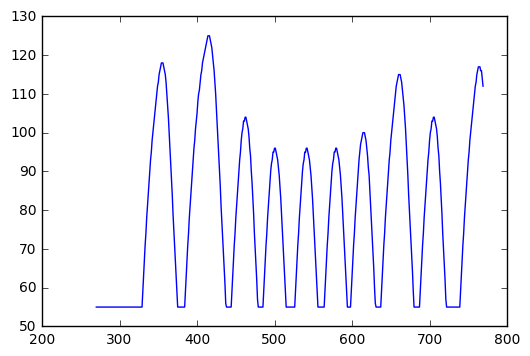

In [103]:

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for trackID in sorted(tracks[0]):
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track[:500,:]
plt.plot(track[:,0],256-track[:,2])
plt.show()


In [5]:
def thresholds(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    max_v = min(vals)
    min_v = max(vals)
    thresholds = set([0, min_v, max_v])
    for t, v in enumerate(vals):
        if (t - last_diff_t) == t_window:
            thresholds.add(last_diff)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return thresholds

axis = 2
window = 3

velocities = track[1:,axis]-track[:-1,axis] 

thresholds(velocities)

{-4, -3, -2, -1, 0, 4, 5}

In [6]:
def samey_intervals(vals, t_window=5):
    last_diff = 0
    last_diff_t = 0
    intervals = []
    for t, v in enumerate(vals):
        if ((t - last_diff_t) >= t_window) and v != last_diff:
            intervals.append(last_diff_t)
            intervals.append(t-1)
            intervals.append(t)
        if v != last_diff:
            last_diff = v
            last_diff_t = t
    return intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)

print velocities

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -2 -2
 -2 -2 -2 -2 -1 -2 -1 -1 -1  0  0  1  1  1  2  3  3  3  4  4  4  4  4  5  4
  4  4  4  4  4  0  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3
 -3 -2 -3 -2 -2 -3 -2 -1 -2 -2 -1 -2 -1 -1 -1 -1 -1 -1 -1  0  0  1  1  1  2
  2  2  3  3  4  4  4  4  4  4  5  4  4  4  4  4  5  1  0  0  0  0  0  0 -4
 -4 -4 -4 -3 -4 -3 -3 -3 -3 -3 -2 -3 -2 -1 -2  0 -1  0  1  1  1  2  3  2  4
  3  4  4  5  4  4  4  5  2  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3
 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0
  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1
  2  2  3  3  4  4  4  4  4  4  4  0  0  0  0  0  0  0  0 -4 -4 -4 -4 -3 -4
 -3 -3 -3 -3 -2 -1 -2  0 -1  0  1  1  1  2  2  3  3  4  4  4  4  4  4  4  0
  0  0  0 -4

In [7]:
def zero_crossings(vals):
    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]
    for t, v in enumerate(vsigns):
        if last_sign == 0:
            last_sign = v
        elif v == 0 or v == last_sign:
            continue
        elif v != last_sign:
            sign_intervals.append(last_sign_change)
            sign_intervals.append(t-1)
            sign_intervals.append(t)
            sign_intervals.append(t+1)
            last_sign = v
            last_sign_change = t
    if t - 1 != last_sign_change:
        sign_intervals.append(last_sign_change)
        sign_intervals.append(t)
    return sign_intervals

axis = 2
window = 2

velocities = track[1:,axis]-track[:-1,axis] 
smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(window)/window)


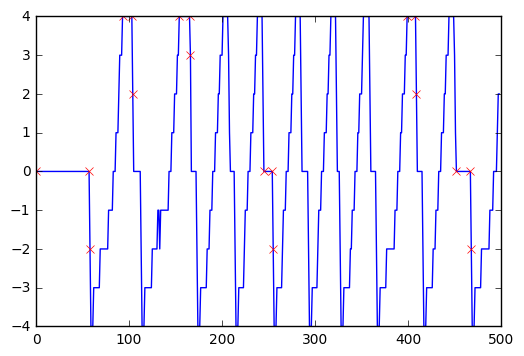

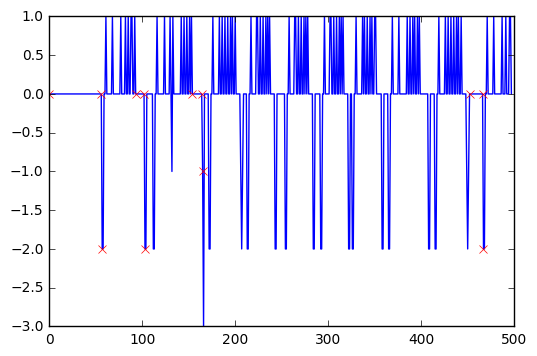

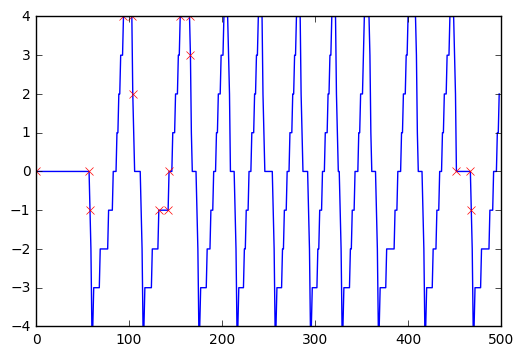

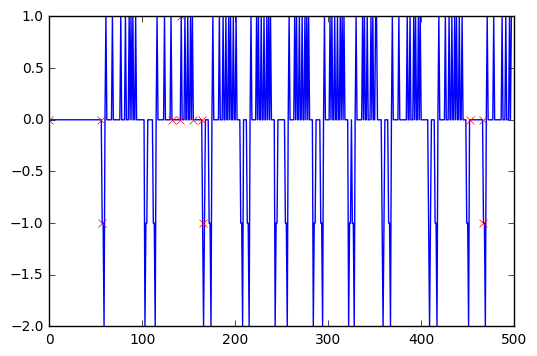

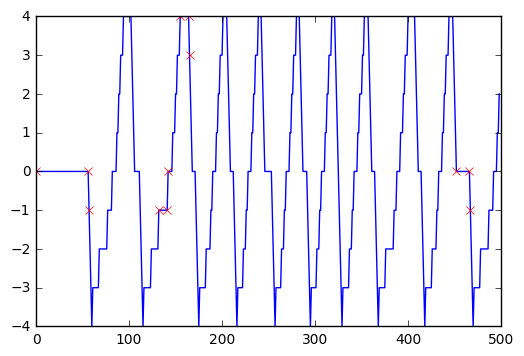

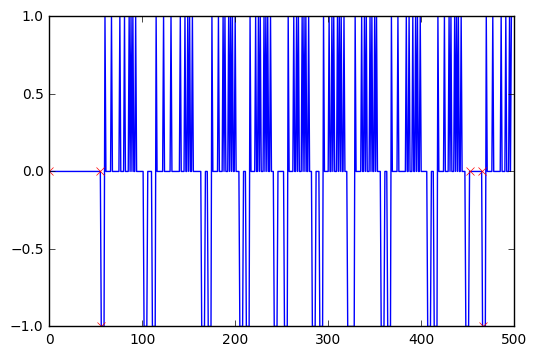

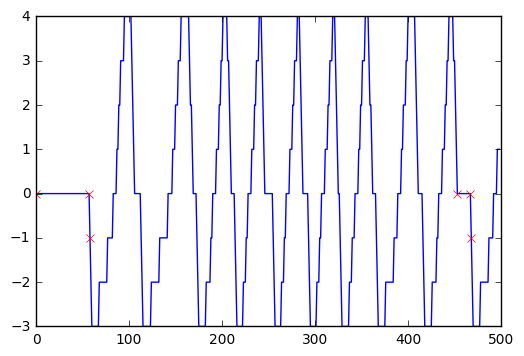

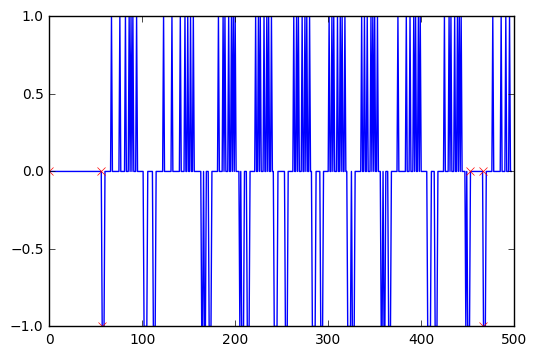

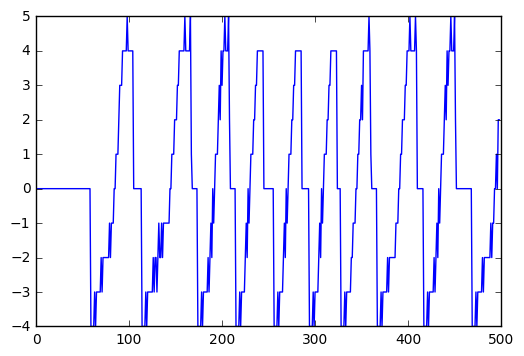

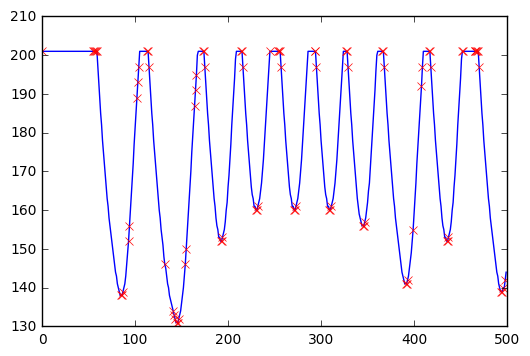

In [15]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 10

switch_points = set(zero_crossings(velocities))

smoothed_points = set(samey_intervals(velocities,t_window=same_window))
for w in range(2,6):
    smoothed = scipy.ndimage.filters.convolve1d(velocities, np.ones(w)/w)
    #print smoothed
    plt.plot(smoothed)
    points = samey_intervals(smoothed,t_window=same_window)
    smoothed_points |= set(points)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    smoothed = smoothed[1:]-smoothed[:-1]
    points = samey_intervals(smoothed,t_window=same_window)
    smoothed_points |= set(points)
    
    plt.plot(smoothed)
    plt.plot(np.array(points),smoothed[np.array(points,dtype='int')],'rx')
    plt.show()
    

velocity_times = sorted(switch_points |smoothed_points)

plt.plot(velocities)
plt.show()

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')
plt.show()


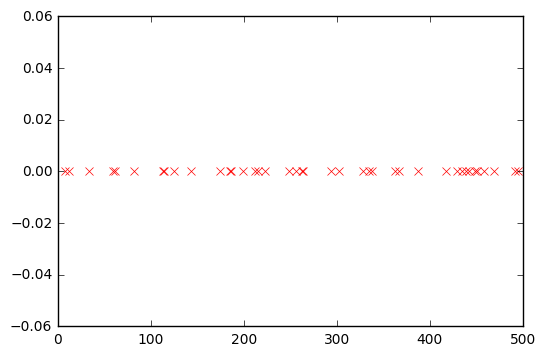

In [8]:
import fceulib
inputVec = fceulib.readInputs('Illustrative.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)

plt.plot(np.array(button_times),np.array(button_times)*0,'rx')
plt.show()

In [9]:
# Templates is an array of model-generating functions of increasing complexity.
templates = [
    # Constant 0 velocity
    ("c0",lambda n,axis,vs,pv: pm.Normal(
        n, 
        mu=0,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant velocity from old value
    ("cP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv,
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Fixed constant velocity
    ("cN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10),
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from 0
    ("acc0",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from old velocity value
    ("accP",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pv+pm.Normal(n+"_acc",mu=0,sd=10)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
    # Constant acceleration from fixed constant velocity
    ("accN",lambda n,axis,vs,pv: pm.Normal(
        n,
        mu=pm.Normal(n+"_N",mu=0,sd=10)+pm.Normal(n+"_acc",mu=0,sd=20)*vs[:,0],
        sd=pm.HalfCauchy(n+"_err",beta=10),
        observed=vs[:,axis]
    )),
]
templates = templates
type2ind = {t[0]:i for i,t in enumerate(templates)}
print type2ind

{'accN': 5, 'cN': 2, 'acc0': 3, 'c0': 0, 'cP': 1, 'accP': 4}


In [10]:
iterations = 5000
def model_template_generate(template_i, axis, segment, prev_val):
    axisNames = [None,"x","y"]
    template = templates[template_i]
    (tn, t) = template
    with pm.Model() as model:
        lik = t(axisNames[axis],axis,segment,prev_val)
        step = pm.Metropolis()
        trace = pm.sample(iterations, step, progressbar=True)
        subtrace = trace[len(trace)/2:-1:10]
    return (tn,model,subtrace)

In [11]:
def model_set_generate(data):
    track,all_times,axis,i,j = data
    t0 = all_times[i]
    t1 = all_times[j]
    print "go",i,j,t0,t1
    if t0 == 0:
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = float('inf')
    elif t1+1 > np.shape(track)[1]:
        extended_track = np.concatenate((track,[track[-1]]))
        segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    else:
        #9,10,11 - 8,9,10
        segment = track[t0+1:t1+1]-track[t0:t1]
        prev_vel = track[t0,axis]-track[t0-1,axis]
    segment[:,0] = range(0,np.shape(segment)[0])
    result = map(
        lambda ti: model_template_generate(ti, 
                                           axis,
                                           segment,
                                           prev_vel),
        range(0,len(templates)))
    return (i,j,t0,t1,result)

In [16]:
iterations = 5000
all_times = sorted(set(velocity_times + button_times))

all_times = all_times[:100]#[:len(all_times)/4]

In [ ]:
%%time
likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for i in range(0,len(all_times)):
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    print t0
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]:
        js = model_set_generate((track,all_times,axis,i,j))
        the_templates = js[-1]
        foundOne = False
        for tn,mod,trace in the_templates:
            logp = -np.mean([mod.logp(pt) for pt in trace])/float(all_times[j]-all_times[i])
            print logp
            if logp < min_likelihood:
                min_likelihood = logp
                foundOne = True
        if not foundOne:
            break
        likes[i][j] = js
        
    #js = map(model_set_generate,
    #         map(lambda j:(track,all_times,axis,i,j), [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval]))
    #likes[i][i+1:len(all_times)] = js

pickle.dump(likes,open('mario_likes.pkl','wb'))
print "Done!"

In [12]:
for li in likes[0:10]:
    for lij in li[0:10]:
        if lij is None or lij == []: 
            continue
        (i,j,t0,t1,models) = lij
        print i,j,t0,t1
        for m in models:
            print m[0],pm.df_summary(m[-1])
        print "\n"

0 1 0 8
c0                 mean             sd       mc_error        hpd_2.5  \
y_err  8.701270e-155  1.541330e-155  1.174171e-156  7.462854e-155   

            hpd_97.5  
y_err  1.130737e-154  
cP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_err  10.0  1.776357e-15       0.0     10.0      10.0
cN                mean            sd      mc_error       hpd_2.5      hpd_97.5
y_N    3.240278e-17  2.164272e-16  2.385801e-17 -8.280052e-16  1.287338e-17
y_err  7.084212e-17  2.759680e-16  2.912174e-17  1.094506e-28  7.434719e-16
acc0                mean            sd      mc_error       hpd_2.5      hpd_97.5
y_acc -2.129019e-19  1.063400e-18  1.151650e-19 -7.123379e-22  2.379807e-19
y_err  1.266095e-18  5.647458e-18  6.029002e-19  9.965012e-31  1.721709e-18
accP        mean            sd  mc_error  hpd_2.5  hpd_97.5
y_acc   0.0  0.000000e+00       0.0      0.0       0.0
y_err  10.0  1.776357e-15       0.0     10.0      10.0
accN                mean            sd      mc_error     

In [17]:
%%time
# What is the mode as of just before each switch-point, 
# and what is the accumulated cost of the approximation up to that point?
modes = [(0,None)]*(len(all_times))

#modes is offset from likes by 1

ks = {"c0":1, "cP":1, "cN":2, "acc0":2, "accP":2, "accN":3}

cost = 1

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 4 

for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    print "j",j
    for i in range(0, j):
        data = likes[i][j]
        if not data:
            continue
        dt = data[3]-data[2]
        if dt < min_interval:
            print data[:4]
            continue
        the_templates = data[-1]
        print "i",i
        for tn,mod,trace in the_templates:
            k = ks[tn]
            summary = pm.df_summary(trace)
            logp = np.mean([mod.logp(pt) for pt in trace])
            # WAIC
            #crit = -pm.stats.waic(model=mod,trace=trace)
            # DIC
            crit = pm.stats.dic(model=mod,trace=trace)
            if np.abs(crit) > 1e5:
                crit = float('inf')
            # BPIC
            #crit = pm.stats.bpic(model=mod,trace=trace)
            # AICc
            #crit = 2*k - 2 * logp + (2*(k+1)*(k+2))/(dt-k-2)
            # BIC
            #crit = math.log(dt)*k - 2 * logp
            # max-likelihood
            #crit = -logp
            
            #crit = math.log(dt) - logp
            m_prev = modes[i][0]
            # ??
            crit = summary["mean"]["y_err"]*dt
            here = crit + m_prev + cost
            print i,j,data[2],data[3],tn,logp,summary["mean"]["y_err"],crit,here,least
            if here < least:
                print "update least",here
                least = here
                # prev_i,this_j,t0,t1,name,summary,criterion
                least_template = (i,j,data[2],data[3],tn,summary,crit)
    modes[j] = (least, least_template)

map(lambda m:m[1],modes)

j 1
i 0
0 1 0 8 c0 2473.13803211 8.70127019444e-155 6.96101615555e-154 1.0 inf
update least 1.0
0 1 0 8 cP -inf 10.0000003198 80.000002558 81.000002558 1.0
0 1 0 8 cN 333.00889087 7.0842119872e-17 5.66736958976e-16 1.0 1.0
0 1 0 8 acc0 365.346878892 1.26609543431e-18 1.01287634744e-17 1.0 1.0
0 1 0 8 accP -inf 10.0000003198 80.000002558 81.000002558 1.0
0 1 0 8 accN 190.374064136 4.05400630926e-11 3.24320504741e-10 1.00000000032 1.0
j 2
i 0
0 2 0 12 c0 3889.0007012 8.22079016294e-155 9.86494819552e-154 1.0 inf
update least 1.0
0 2 0 12 cP -inf 10.0000003198 120.000003837 121.000003837 1.0
0 2 0 12 cN 554.776134364 3.06657658511e-17 3.67989190214e-16 1.0 1.0
0 2 0 12 acc0 3885.71343181 8.26599879036e-155 9.91919854843e-154 1.0 1.0
0 2 0 12 accP -inf 10.0000003198 120.000003837 121.000003837 1.0
0 2 0 12 accN 322.272909619 3.28263980252e-11 3.93916776302e-10 1.00000000039 1.0
j 3
i 0
0 3 0 33 c0 11322.3570303 7.72091007123e-155 2.54790032351e-153 1.0 inf
update least 1.0
0 3 0 33 cP -inf

[None,
 (0,
  1,
  0,
  8,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  8.701270e-155  1.541330e-155  1.174171e-156  7.462854e-155   
  
              hpd_97.5  
  y_err  1.130737e-154  ,
  6.9610161555495067e-154),
 (0,
  2,
  0,
  12,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  8.220790e-155  8.015870e-156  6.480788e-157  7.462232e-155   
  
              hpd_97.5  
  y_err  1.000338e-154  ,
  9.8649481955226476e-154),
 (0,
  3,
  0,
  33,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  7.720910e-155  2.790787e-156  2.076320e-157  7.458504e-155   
  
              hpd_97.5  
  y_err  8.266647e-155  ,
  2.5479003235056748e-153),
 (0,
  4,
  0,
  55,
  'c0',
                  mean             sd       mc_error        hpd_2.5  \
  y_err  7.586006e-155  1.231261e-156  8.765994e-158  7.460163e-155   
  
              hpd_97.5  
  y_err  7.844019e-155  ,
  4.172303

In [18]:
def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',p[1],'\n'

0 1.0 
(0, 8, 0, 59, 'c0',                 mean             sd       mc_error        hpd_2.5  \
y_err  7.595127e-155  1.270930e-156  8.786532e-158  7.460279e-155   

            hpd_97.5  
y_err  7.883908e-155  , 4.4811246806233116e-153) 

1 10.9192279943 
(8, 10, 59, 82, 'accN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N   -4.075238  0.143706  0.012029 -4.339944 -3.797545
y_acc  0.129272  0.011404  0.001013  0.106972  0.150295
y_err  0.387793  0.062123  0.004571  0.289020  0.516100, 8.9192279943330242) 

2 16.1632688301 
(10, 14, 82, 93, 'accP',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_acc  0.426478  0.020984  0.001442  0.388697  0.466805
y_err  0.385822  0.109680  0.007805  0.201506  0.612768, 4.2440408357496882) 

3 20.9453588842 
(14, 18, 93, 104, 'cN',            mean        sd  mc_error   hpd_2.5  hpd_97.5
y_N    4.094289  0.093727  0.007349  3.899290  4.270111
y_err  0.343826  0.086483  0.006058  0.211659  0.541419, 3.782090054080351) 

4 35.334

In [19]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


In [20]:
cross = {}
unions = UnionFind()

for ii,mode in enumerate(path):
    d = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}
    model,trace = {t[0]:t[1:] for t in likes[mode[1][0]][mode[1][1]][4]}[mode[1][4]]
    for jj,mode2 in enumerate(path):
        model2,trace2 = {t[0]:t[1:] for t in likes[mode2[1][0]][mode2[1][1]][4]}[mode2[1][4]]
        if mode2[1][4] == mode[1][4]:
            try:
                crit = -np.mean([model.logp(pt) for pt in trace2])#pm.stats.dic(model=model,trace=trace2)
            except:

                crit = float('inf')
        else:
            crit = float('inf')
        cross[(ii,jj)] = crit

In [21]:
complexityWeight = 20
for d in sorted(cross):
    good = True
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])])
   
    if (joined < (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
merged = {}
for u in unions:
    print u, unions[u]
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print merged

0 14
1 5
2 6
3 7
4 11
5 5
6 6
7 7
8 6
9 5
10 6
11 11
12 5
13 11
14 14
15 5
16 6
17 11
18 5
19 7
20 5
21 11
22 7
23 14
24 5
25 11
26 7
27 6
28 5
29 6
30 30
{5: set([1, 5, 9, 12, 15, 18, 20, 24, 28]), 6: set([2, 6, 8, 10, 16, 27, 29]), 7: set([19, 26, 3, 22, 7]), 11: set([4, 11, 13, 17, 21, 25]), 14: set([0, 14, 23]), 30: set([30])}


In [126]:
iterations = 1000

def model_sets_generate2(ti,data):
    track,all_times,axis,i,j = data
    segments = []
    for ind in range(len(i)):
        t0 = all_times[i[ind]]
        t1 = all_times[j[ind]]
        if t0 == 0:
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = 0
        elif t1+1 > np.shape(track)[1]:
            extended_track = np.concatenate((track,[track[-1]]))
            segment = extended_track[t0+1:t1+1]-extended_track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        else:
            #9,10,11 - 8,9,10
            segment = track[t0+1:t1+1]-track[t0:t1]
            prev_vel = track[t0,axis]-track[t0-1,axis]
        segment[:,0] = range(0,np.shape(segment)[0])
        segments.append(segment)
    segment = np.vstack(segments)
    result = model_template_generate(ti, 
                                       axis,
                                       segment,
                                       prev_vel)
    return (i,j,t0,t1,result)

for m in merged:
    print ''
    if len(merged[m]) > 1:
        i_ = []
        j_ = []
        for t in merged[m]:
            mode = path[t]
            dat = likes[mode[1][0]][mode[1][1]]
            ti = type2ind[mode[1][4]]
            i_.append(dat[0])
            j_.append(dat[1])
        result = model_sets_generate2(ti,(track,all_times,axis,i_,j_))
        print m,result
        #pm.summary(result[4][2])
        #print pm.df_summary(result[4][2])

Applied log-transform to y_err and added transformed y_err_log_ to model.


100%|██████████| 1000/1000 [00:00<00:00, 5416.39it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


5 ([8, 20, 36, 46, 56, 64, 71, 80, 90], [10, 25, 38, 50, 59, 67, 74, 82, 92], 417, 429, ('accN', <pymc3.model.Model object at 0x1f2cc9a90>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 7502.27it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


6 ([10, 25, 32, 38, 59, 87, 92], [14, 30, 36, 43, 62, 90, 94], 429, 435, ('accP', <pymc3.model.Model object at 0x1f5d57750>, <MultiTrace: 1 chains, 50 iterations, 3 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 6889.94it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


7 ([67, 86, 14, 77, 30], [71, 87, 18, 78, 32], 154, 164, ('cN', <pymc3.model.Model object at 0x1f6495150>, <MultiTrace: 1 chains, 50 iterations, 3 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 5432.48it/s]
Applied log-transform to y_err and added transformed y_err_log_ to model.


11 ([18, 43, 50, 62, 74, 82], [20, 46, 52, 64, 77, 86], 387, 399, ('accN', <pymc3.model.Model object at 0x1f6d40ad0>, <MultiTrace: 1 chains, 50 iterations, 4 variables>))



100%|██████████| 1000/1000 [00:00<00:00, 14988.22it/s]

14 ([0, 52, 78], [8, 56, 80], 362, 367, ('c0', <pymc3.model.Model object at 0x1f73cd3d0>, <MultiTrace: 1 chains, 50 iterations, 2 variables>))



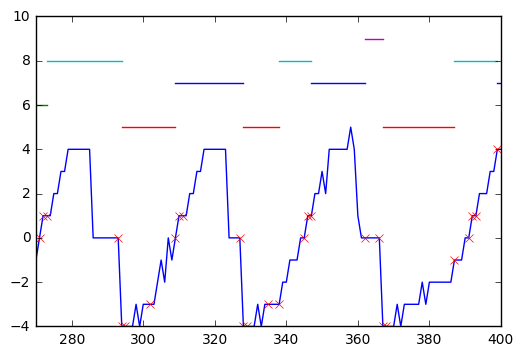

In [197]:
colors = ['r','g','b','c','m','y','k',"#aa0000","#00aa00","#0000aa","#880000","#008800","#000088"]
merged2color = {m:i for i,m in enumerate(sorted(merged))}

for m in merged:
    for t in merged[m]:
        plt.plot(np.array(path[t][1][2:4]),np.array([merged2color[m], merged2color[m]])+5,colors[merged2color[m]])

plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.xlim((270,400))
plt.show()

In [211]:
collisions = pickle.load(open('mario_collisions.pkl'))

def button_changes(button_masks):
    last_mask = 0
    mask_times = {}
    for t, b in enumerate(button_masks):
        b_ = int(b)
        buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if b_ & (1 << (7-ii)):
                buttons.append(c)
        l_ = int(last_mask)
        last_buttons = []
        for ii,c in enumerate(list('RLDUTSBA')):
            if l_ & (1 << (7-ii)):
                last_buttons.append(c)
        mask_times[t] = (tuple(last_buttons),tuple(buttons))
        last_mask = b
    
    return mask_times

button_change_times = button_changes(inputVec)
for t in sorted(button_change_times):
    print t, button_change_times[t]

0 ((), ())
1 ((), ())
2 ((), ())
3 ((), ())
4 ((), ())
5 ((), ())
6 ((), ())
7 ((), ())
8 ((), ())
9 ((), ())
10 ((), ())
11 ((), ())
12 ((), ())
13 ((), ())
14 ((), ())
15 ((), ())
16 ((), ())
17 ((), ())
18 ((), ())
19 ((), ())
20 ((), ())
21 ((), ())
22 ((), ())
23 ((), ())
24 ((), ())
25 ((), ())
26 ((), ())
27 ((), ())
28 ((), ())
29 ((), ())
30 ((), ())
31 ((), ())
32 ((), ())
33 ((), ())
34 ((), ())
35 ((), ())
36 ((), ())
37 ((), ())
38 ((), ())
39 ((), ())
40 ((), ())
41 ((), ())
42 ((), ())
43 ((), ())
44 ((), ())
45 ((), ())
46 ((), ())
47 ((), ())
48 ((), ())
49 ((), ())
50 ((), ())
51 ((), ())
52 ((), ())
53 ((), ())
54 ((), ())
55 ((), ())
56 ((), ())
57 ((), ())
58 ((), ())
59 ((), ())
60 ((), ())
61 ((), ())
62 ((), ())
63 ((), ())
64 ((), ())
65 ((), ())
66 ((), ())
67 ((), ())
68 ((), ())
69 ((), ())
70 ((), ())
71 ((), ())
72 ((), ())
73 ((), ())
74 ((), ())
75 ((), ())
76 ((), ())
77 ((), ())
78 ((), ())
79 ((), ())
80 ((), ())
81 ((), ())
82 ((), ())
83 ((), ())
84

In [212]:
def sign(num):
    if num < 0:
        return -1
    if num > 0:
        return 1
    return 0

def button_diff(btnsA, btnsB):
    return set(btnsA) - set(btnsB)

def button_intersect(btnsA, btnsB):
    return set(btnsA) & set(btnsB)

def button_union(btnsA, btnsB):
    return set(btnsA) | set(btnsB)

def button_preds(button_pairs):
    here_i = set()
    for bp in button_pairs:
        released_i = button_diff(bp[0], bp[1])
        pressed_i = button_diff(bp[1], bp[0])    
        held_i = bp[1]
        for ri in released_i:
            here_i.add(("release",ri))
        for ri in pressed_i:
            here_i.add(("press",ri))
        for ri in held_i:
            here_i.add(("hold",ri))
    return list(here_i)

In [219]:
start_time = 270
transitions = {}
# Edges into [outer] from [inner]
entries_from = {m: {m: [] for m in merged} 
                for m in merged}
# Edges into [outer]
entries = {m: [] for m in merged}
for t in range(1,len(path)):
    if t == 0:
        prev = -1
    else:
        prev = unions[t-1]

    start = path[t][1][2]
    entries_from[unions[t]][prev].append(start)
    entries[unions[t]].append(start)
    transitions[start] = (prev,unions[t])

preds = [set()]*len(velocities)
for t in range(0,len(velocities)):
    psi = ([button_change_times[start_time+t+i]
            for i in range(-1, 1)],
            #  TODO: stopped colliding/started colliding?
            (collisions.get(start_time+t,set()) |
             collisions.get(start_time+t-1,set())),
            (velocities[t-1],velocities[t])
          )
    buttons_i = psi[0]
    here_i = button_preds(buttons_i)
    for coli in psi[1]:
        here_i.append(("col",coli))
    vel0,vel1 = psi[2]
    if vel0 < vel1:
        here_i.append(("acc",1))
    if vel0 > vel1:
        here_i.append(("acc",-1))
    if vel0 == vel1:
        here_i.append(("acc",0))
    if vel0 < 0 and vel1 > 0:
        here_i.append(("zc",1))
    if vel0 > 0 and vel1 < 0:
        here_i.append(("zc",-1))
    if vel0 < 0 and vel1 == 0:
        here_i.append(("zin",1))
    if vel0 > 0 and vel1 == 0:
        here_i.append(("zin",-1))
    if vel0 == 0 and vel1 < 0:
        here_i.append(("zout",-1))
    if vel0 == 0 and vel1 > 0:
        here_i.append(("zout",1))
    preds[t] = set(here_i)


Now, we need to use NPMI to figure out which conditions are likely to be important to the learned transitions.

In [230]:


def count_cooccurrences(pred_sets,ignored):
    ocs = {}
    coocs = {}
    nice_pred_sets = []
    for pi in range(0, len(pred_sets)):
        here_i = pred_sets[pi]
        here_i = list(set(here_i) - ignored)
        for pred in here_i:
            ocs[pred] = ocs.get(pred,0)+1
        for predii in range(0,len(here_i)):
            if here_i[predii] not in coocs:
                coocs[here_i[predii]] = {}
            for predij in range(0,len(here_i)):
                coocs[here_i[predii]][here_i[predij]] = coocs[here_i[predii]].get(here_i[predij],0)+1
        nice_pred_sets.append(here_i)
    return nice_pred_sets,ocs,coocs


def calc_npmi(pred_sets, ocs, coocs):
    maximum = float(len(pred_sets))
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in ocs.items():
        px = countx / maximum
        probs[predx] = px
        for predy,countxy in coocs[predx].items():
            py = ocs[predy] / maximum
            pxy = countxy / maximum
            d = (math.log(px*py)/math.log(pxy) - 1) if pxy != 1 else 1
            npmis[(predx,predy)] = d
    return probs,npmis

def calc_npmi_pred_edge(all_ocs, all_edge_ocs, edge_count, all_edge_count):
    npmis = {}
    probs = {}
    # How likely are individual predicates to co-occur 
    #  within the transitions to a given target?
    for predx,countx in all_ocs.items():
        px = countx / float(all_edge_count)
        py = edge_count / float(all_edge_count)
        pxy = all_edge_ocs.get(predx,0) / float(all_edge_count)
        probs[predx] = all_edge_ocs.get(predx,0) / float(edge_count)
        assert px <= 1, (px,countx,all_edge_count)
        assert py <= 1, (py,edge_count,all_edge_count)
        assert pxy <= 1, (pxy,all_edge_ocs.get(predx,0),float(edge_count))
        if pxy == 0:
            d = -1
        elif pxy == 1:
            d = 1
        else:
            d = (math.log(px*py)/math.log(pxy) - 1)
        npmis[predx] = d
    return probs,npmis

all_counts = {}
counts_by_time = {}
for t,ps in enumerate(preds):
    counts_by_time[t] = {}
    for p in ps:
        all_counts[p] = all_counts.get(p,0)+1
        counts_by_time[t][p] = counts_by_time[t].get(p,0)+1
    if t in transitions:
        tr = transitions[t]
        key = ("tr",tr)
        all_counts[key] = all_counts.get(key,0)+1
        counts_by_time[t][key] = counts_by_time[t].get(key,0)+1
        (_,dest) = tr
        keystar = ("tr",("*",dest))
        all_counts[keystar] = all_counts.get(keystar,0)+1
        counts_by_time[t][keystar] = counts_by_time[t].get(keystar,0)+1

def calc_npmi(pred1, pred2, all_counts, counts_by_time):
    norm = float(len(counts_by_time))
    count1 = all_counts[pred1]
    count2 = all_counts[pred2]
    count12 = 0
    for t,cs in counts_by_time.items():
        count12 += cs.get(pred1,0) * cs.get(pred2,0)
    p1 = count1 / norm
    p2 = count2 / norm
    p12 = count12 / norm
    if p12 == 0:
        d = -1
    elif p12 == 1:
        d = 1
    else:
        d = math.log(p1*p2)/math.log(p12) - 1
    return d
        
# Let's calculate NPMI between predicates and transitions!
npmis = {}
for thing,count in all_counts.items():
    if thing[0] == "tr":
        print "tr:",thing,count
        tr = thing[1]
        # Find NPMI with every predicate
        for thing2,count in all_counts.items():
            if thing2[0] == "tr":
                continue
            if tr not in npmis:
                npmis[tr] = {}
            npmis[tr][thing2] = calc_npmi(thing, 
                                          thing2, 
                                          all_counts,
                                          counts_by_time)
    else:
        pass

for tr,prednpmis in npmis.items():
    print "----"
    print tr
    print "----"
    for pred,pmi in sorted(prednpmis.items(),
                           lambda a,b:sign(b[1]-a[1])):
        print pred,pmi

tr: ('tr', (7, 14)) 1
tr: ('tr', (11, 14)) 1
tr: ('tr', (5, 7)) 1
tr: ('tr', (5, 11)) 3
tr: ('tr', ('*', 11)) 6
tr: ('tr', ('*', 6)) 7
tr: ('tr', (6, 11)) 2
tr: ('tr', (5, 6)) 5
tr: ('tr', (6, 30)) 1
tr: ('tr', ('*', 7)) 5
tr: ('tr', ('*', 5)) 9
tr: ('tr', ('*', 14)) 2
tr: ('tr', (6, 7)) 2
tr: ('tr', (7, 6)) 2
tr: ('tr', (11, 7)) 2
tr: ('tr', (11, 5)) 3
tr: ('tr', (7, 5)) 1
tr: ('tr', (7, 11)) 1
tr: ('tr', ('*', 30)) 1
tr: ('tr', (14, 5)) 3
tr: ('tr', (6, 5)) 2
----
('*', 7)
----
('zin', 1) 0.305043962712
('acc', 1) 0.256069732186
('hold', 'L') 0.12467019072
('col', ((36, 0, 'tile'), 'top')) 0.119405938199
('hold', 'R') 0.0776853166244
('col', ((36, 0, 'tile'), 'right')) 0.0496766153131
('col', ((36, 0, 'tile'), 'internal')) 0.0496766153131
('col', ((36, 0, 'tile'), 'bottom')) 0.0491300950695
('col', ((36, 0, 'tile'), 'left')) 0.0260719521983
('acc', 0) -0.185011642102
('zin', -1) -1
('col', ((51, 0, 'tile'), 'internal')) -1
('col', ((49, 0, 'tile'), 'bottom')) -1
('col', ((181, 1, 'ti